In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "gpu"                 # comment out if CPU
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from jax import config
config.update("jax_enable_x64", True)
import jax
print(jax.default_backend(), jax.devices()) 
from pfcheeshmc import sample_pf_chees_hmc

gpu [CudaDevice(id=0)]


# 8 Schools Example
Based on the famous 8 schools example demonstrating hierarchical models.

In [2]:
import numpy as np
import pymc as pm
import arviz as az

In [3]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfCauchy("tau", 5.0)

    theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
    theta_1 = mu + tau * theta
    obs = pm.Normal("obs", mu=theta_1, sigma=sigma, shape=J, observed=y)
    idata = pm.sample_prior_predictive(1000)

Sampling: [mu, obs, tau, theta]


In [4]:
with model:
    posterior_idata = sample_pf_chees_hmc(draws=2000, chains=32, chees_kwargs={"draws": 10_000})
idata.extend(posterior_idata)

Initializing ChEES-HMC using pathfinder+adapt_diag...


ε Tuning:   0%|          | 0/32 [00:00<?, ?it/s]

ChEES Adaptation:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling Dynamic HMC:   0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
with model:
    post_idata = pm.sample_posterior_predictive(idata, var_names=["obs"])
    idata.extend(post_idata)

Sampling: [obs]


Output()

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

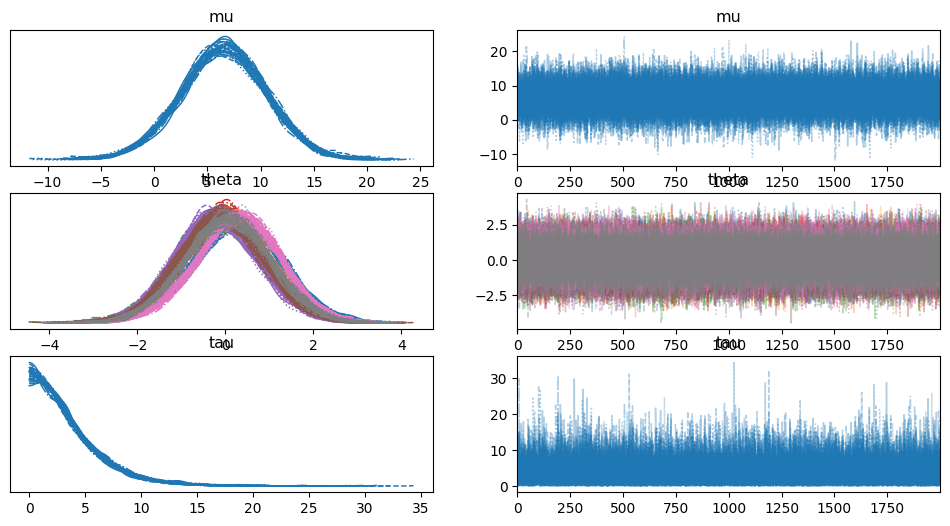

In [6]:
az.plot_trace(posterior_idata)

In [7]:
az.summary(posterior_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,6.536,4.057,-0.943,14.364,0.021,0.019,36700.0,34582.0,1.0
theta[0],0.288,0.986,-1.596,2.131,0.004,0.004,58284.0,45596.0,1.0
theta[1],0.037,0.942,-1.751,1.807,0.004,0.005,48316.0,37729.0,1.0
theta[2],-0.114,0.973,-1.928,1.741,0.004,0.005,51885.0,34961.0,1.0
theta[3],0.018,0.956,-1.739,1.842,0.004,0.005,47036.0,35897.0,1.0
theta[4],-0.215,0.942,-1.974,1.597,0.005,0.005,43672.0,35584.0,1.0
theta[5],-0.120,0.954,-1.875,1.722,0.004,0.005,46471.0,34471.0,1.0
theta[6],0.295,0.953,-1.515,2.072,0.004,0.004,56059.0,45022.0,1.0
theta[7],0.052,0.972,-1.810,1.855,0.004,0.005,53338.0,36789.0,1.0
tau,3.564,3.119,0.000,9.098,0.015,0.020,36126.0,32773.0,1.0
